In [8]:
#!/usr/bin/python
#
# Copyright 2018 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#      http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import argparse
import functools
import os
import json
import math
from collections import defaultdict
import random

import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision.models as models

import sys
sys.path.append('../')
from sg2im.data import imagenet_deprocess_batch
import sg2im.data.vg as vg_no_style
import sg2im.data.vg_style_inject as vg_style_inject
from sg2im.discriminators import PatchDiscriminator, AcCropDiscriminator
from sg2im.losses import get_gan_losses
from sg2im.metrics import jaccard
from sg2im.model import Sg2ImModel
from sg2im.utils import int_tuple, float_tuple, str_tuple
from sg2im.utils import timeit, bool_flag, LossManager

# Our stylegan implementation
from sg2im.style_loss import StyleLossModule
from sg2im.stylegan_layers import GMapping
import matplotlib.pyplot as plt


In [9]:
torch.backends.cudnn.benchmark = True

VG_DIR = os.path.expanduser('/vision2/u/helenav/datasets/vg')
COCO_DIR = os.path.expanduser('datasets/coco')

parser = argparse.ArgumentParser()
parser.add_argument('--dataset', default='vg', choices=['vg', 'coco'])

# Optimization hyperparameters
parser.add_argument('--batch_size', default=32, type=int)
parser.add_argument('--num_iterations', default=160000, type=int)
parser.add_argument('--learning_rate', default=1e-4, type=float)

# Switch the generator to eval mode after this many iterations
parser.add_argument('--eval_mode_after', default=100000, type=int)

# Dataset options common to both VG and COCO
parser.add_argument('--image_size', default='64,64', type=int_tuple)
parser.add_argument('--num_train_samples', default=None, type=int)
parser.add_argument('--num_val_samples', default=1024, type=int)
parser.add_argument('--shuffle_val', default=True, type=bool_flag)
parser.add_argument('--loader_num_workers', default=4, type=int)
parser.add_argument('--include_relationships', default=True, type=bool_flag)

# VG-specific options
parser.add_argument('--vg_image_dir', default=os.path.join(VG_DIR, 'images'))
parser.add_argument('--train_h5', default=os.path.join('/scr/helenav/datasets/preprocess_vg', 'stylized_train.h5'))
parser.add_argument('--val_h5', default=os.path.join('/scr/helenav/datasets/preprocess_vg', 'stylized_val.h5'))
parser.add_argument('--vocab_json', default=os.path.join('/scr/helenav/datasets/preprocess_vg', 'vocab.json'))
parser.add_argument('--max_objects_per_image', default=10, type=int)
parser.add_argument('--vg_use_orphaned_objects', default=True, type=bool_flag)

# COCO-specific options
parser.add_argument('--coco_train_image_dir',
         default=os.path.join(COCO_DIR, 'images/train2017'))
parser.add_argument('--coco_val_image_dir',
         default=os.path.join(COCO_DIR, 'images/val2017'))
parser.add_argument('--coco_train_instances_json',
         default=os.path.join(COCO_DIR, 'annotations/instances_train2017.json'))
parser.add_argument('--coco_train_stuff_json',
         default=os.path.join(COCO_DIR, 'annotations/stuff_train2017.json'))
parser.add_argument('--coco_val_instances_json',
         default=os.path.join(COCO_DIR, 'annotations/instances_val2017.json'))
parser.add_argument('--coco_val_stuff_json',
         default=os.path.join(COCO_DIR, 'annotations/stuff_val2017.json'))
parser.add_argument('--instance_whitelist', default=None, type=str_tuple)
parser.add_argument('--stuff_whitelist', default=None, type=str_tuple)
parser.add_argument('--coco_include_other', default=False, type=bool_flag)
parser.add_argument('--min_object_size', default=0.02, type=float)
parser.add_argument('--min_objects_per_image', default=3, type=int)
parser.add_argument('--coco_stuff_only', default=True, type=bool_flag)

# Generator options
parser.add_argument('--mask_size', default=16, type=int) # Set this to 0 to use no masks
parser.add_argument('--embedding_dim', default=128, type=int)
parser.add_argument('--gconv_dim', default=128, type=int)
parser.add_argument('--gconv_hidden_dim', default=512, type=int)
parser.add_argument('--gconv_num_layers', default=5, type=int)
parser.add_argument('--mlp_normalization', default='none', type=str)
parser.add_argument('--refinement_network_dims', default='1024,512,256,128,64', type=int_tuple)
parser.add_argument('--normalization', default='batch')
parser.add_argument('--activation', default='leakyrelu-0.2')
parser.add_argument('--layout_noise_dim', default=32, type=int)
parser.add_argument('--use_boxes_pred_after', default=-1, type=int)
# Style image option
parser.add_argument('--style_image_option', default='use_style')

# Generator losses
parser.add_argument('--mask_loss_weight', default=0, type=float)
parser.add_argument('--l1_pixel_loss_weight', default=1.0, type=float)
parser.add_argument('--bbox_pred_loss_weight', default=10, type=float)
parser.add_argument('--predicate_pred_loss_weight', default=0, type=float) # DEPRECATED

# Generic discriminator options
parser.add_argument('--discriminator_loss_weight', default=0.01, type=float)
parser.add_argument('--gan_loss_type', default='gan')
parser.add_argument('--d_clip', default=None, type=float)
parser.add_argument('--d_normalization', default='batch')
parser.add_argument('--d_padding', default='valid')
parser.add_argument('--d_activation', default='leakyrelu-0.2')

# Object discriminator
parser.add_argument('--d_obj_arch',
    default='C4-64-2,C4-128-2,C4-256-2')
parser.add_argument('--crop_size', default=32, type=int)
parser.add_argument('--d_obj_weight', default=1.0, type=float) # multiplied by d_loss_weight 
parser.add_argument('--ac_loss_weight', default=0.1, type=float)

# Image discriminator
parser.add_argument('--d_img_arch',
    default='C4-64-2,C4-128-2,C4-256-2')
parser.add_argument('--d_img_weight', default=1.0, type=float) # multiplied by d_loss_weight

# Output options
parser.add_argument('--print_every', default=10, type=int)
parser.add_argument('--timing', default=False, type=bool_flag)
parser.add_argument('--checkpoint_every', default=10000, type=int)
parser.add_argument('--output_dir', default='/scr/helenav/checkpoints_simsg/inject_with_style_image_train/style_weight_1')
parser.add_argument('--checkpoint_name', default='checkpoint')
parser.add_argument('--checkpoint_start_from', default=None)
parser.add_argument('--restore_from_checkpoint', default=False, type=bool_flag)

# Style weight
parser.add_argument('--style_weight', default=1, type=int)
parser.add_argument('--stylized_dir', default='/vision2/u/helenav/datasets/vg_style')
parser.add_argument('--style_reference_dir', default='/vision2/u/helenav/datasets/style-images')
args = parser.parse_args('')

def add_loss(total_loss, curr_loss, loss_dict, loss_name, weight=1):
  curr_loss = curr_loss * weight
  loss_dict[loss_name] = curr_loss.item()
  if total_loss is not None:
    total_loss += curr_loss
  else:
    total_loss = curr_loss
  return total_loss


def check_args(args):
  H, W = args.image_size
  for _ in args.refinement_network_dims[1:]:
    H = H // 2
  if H == 0:
    raise ValueError("Too many layers in refinement network")


def build_model(args, vocab):
  if args.checkpoint_start_from is not None:
    checkpoint = torch.load(args.checkpoint_start_from)
    kwargs = checkpoint['model_kwargs']
    model = Sg2ImModel(**kwargs)
    raw_state_dict = checkpoint['model_state']
    state_dict = {}
    for k, v in raw_state_dict.items():
      if k.startswith('module.'):
        k = k[7:]
      state_dict[k] = v
    model.load_state_dict(state_dict)
  else:
    kwargs = {
      'vocab': vocab,
      'image_size': args.image_size,
      'embedding_dim': args.embedding_dim,
      'gconv_dim': args.gconv_dim,
      'gconv_hidden_dim': args.gconv_hidden_dim,
      'gconv_num_layers': args.gconv_num_layers,
      'mlp_normalization': args.mlp_normalization,
      'refinement_dims': args.refinement_network_dims,
      'normalization': args.normalization,
      'activation': args.activation,
      'mask_size': args.mask_size,
      'layout_noise_dim': args.layout_noise_dim,
      'num_stylish': 0
    }
    model = Sg2ImModel(**kwargs)
  return model, kwargs


def build_obj_discriminator(args, vocab):
  discriminator = None
  d_kwargs = {}
  d_weight = args.discriminator_loss_weight
  d_obj_weight = args.d_obj_weight
  if d_weight == 0 or d_obj_weight == 0:
    return discriminator, d_kwargs

  d_kwargs = {
    'vocab': vocab,
    'arch': args.d_obj_arch,
    'normalization': args.d_normalization,
    'activation': args.d_activation,
    'padding': args.d_padding,
    'object_size': args.crop_size,
  }
  discriminator = AcCropDiscriminator(**d_kwargs)
  return discriminator, d_kwargs


def build_img_discriminator(args, vocab):
  discriminator = None
  d_kwargs = {}
  d_weight = args.discriminator_loss_weight
  d_img_weight = args.d_img_weight
  if d_weight == 0 or d_img_weight == 0:
    return discriminator, d_kwargs

  d_kwargs = {
    'arch': args.d_img_arch,
    'normalization': args.d_normalization,
    'activation': args.d_activation,
    'padding': args.d_padding,
  }
  discriminator = PatchDiscriminator(**d_kwargs)
  return discriminator, d_kwargs


def build_coco_dsets(args):
  dset_kwargs = {
    'image_dir': args.coco_train_image_dir,
    'instances_json': args.coco_train_instances_json,
    'stuff_json': args.coco_train_stuff_json,
    'stuff_only': args.coco_stuff_only,
    'image_size': args.image_size,
    'mask_size': args.mask_size,
    'max_samples': args.num_train_samples,
    'min_object_size': args.min_object_size,
    'min_objects_per_image': args.min_objects_per_image,
    'instance_whitelist': args.instance_whitelist,
    'stuff_whitelist': args.stuff_whitelist,
    'include_other': args.coco_include_other,
    'include_relationships': args.include_relationships,
  }
  train_dset = CocoSceneGraphDataset(**dset_kwargs)
  num_objs = train_dset.total_objects()
  num_imgs = len(train_dset)
  print('Training dataset has %d images and %d objects' % (num_imgs, num_objs))
  print('(%.2f objects per image)' % (float(num_objs) / num_imgs))

  dset_kwargs['image_dir'] = args.coco_val_image_dir
  dset_kwargs['instances_json'] = args.coco_val_instances_json
  dset_kwargs['stuff_json'] = args.coco_val_stuff_json
  dset_kwargs['max_samples'] = args.num_val_samples
  val_dset = CocoSceneGraphDataset(**dset_kwargs)

  assert train_dset.vocab == val_dset.vocab
  vocab = json.loads(json.dumps(train_dset.vocab))

  return vocab, train_dset, val_dset


def build_vg_dsets(args):
  with open(args.vocab_json, 'r') as f:
    vocab = json.load(f)
  dset_kwargs = {
    'vocab': vocab,
    'h5_path': args.train_h5,
    'image_dir': args.vg_image_dir,
    'image_size': args.image_size,
    'max_samples': args.num_train_samples,
    'max_objects': args.max_objects_per_image,
    'use_orphaned_objects': args.vg_use_orphaned_objects,
    'include_relationships': args.include_relationships,
    'stylized_dir': args.stylized_dir,
    'style_reference_dir': args.style_reference_dir
  }
  if args.style_image_option == "use_style":
    train_dset = vg_style_inject.VgSceneGraphDataset(**dset_kwargs)
    dset_kwargs['h5_path'] = args.val_h5
    del dset_kwargs['max_samples']
    val_dset = vg_style_inject.VgSceneGraphDataset(**dset_kwargs)
  else:
    del dset_kwargs['style_reference_dir']
    del dset_kwargs['stylized_dir']
    train_dset = vg_no_style.VgSceneGraphDataset(**dset_kwargs)
    dset_kwargs['h5_path'] = args.val_h5
    del dset_kwargs['max_samples']
    val_dset = vg_no_style.VgSceneGraphDataset(**dset_kwargs)
  iter_per_epoch = len(train_dset) // args.batch_size
  print('There are %d iterations per epoch' % iter_per_epoch)
  print(len(train_dset))
  return vocab, train_dset, val_dset


def build_loaders(args):
  if args.dataset == 'vg':
    vocab, train_dset, val_dset = build_vg_dsets(args)
    if args.style_image_option == "use_style":
      collate_fn = vg_style_inject.vg_collate_fn
    else:
      collate_fn = vg_no_style.vg_collate_fn
  elif args.dataset == 'coco':
    vocab, train_dset, val_dset = build_coco_dsets(args)
    collate_fn = coco_collate_fn

  loader_kwargs = {
    'batch_size': args.batch_size,
    'num_workers': args.loader_num_workers,
    'shuffle': True,
    'collate_fn': collate_fn,
  }
  train_loader = DataLoader(train_dset, **loader_kwargs)
  
  loader_kwargs['shuffle'] = args.shuffle_val
  val_loader = DataLoader(val_dset, **loader_kwargs)
  return vocab, train_loader, val_loader


def check_model(args, t, loader, model):
  float_dtype = torch.cuda.FloatTensor
  long_dtype = torch.cuda.LongTensor
  num_samples = 0
  all_losses = defaultdict(list)
  total_iou = 0
  total_boxes = 0
  with torch.no_grad():
    for batch in loader:
      batch = [tensor.cuda() for tensor in batch]
      masks = None
      style_imgs = None
      if len(batch) == 6:
        imgs, objs, boxes, triples, obj_to_img, triple_to_img = batch
      elif len(batch) == 7:
        imgs, objs, boxes, masks, triples, obj_to_img, triple_to_img = batch
      elif len(batch) == 8:
        # using vg_style_inject VgSceneGraphDataset gets styled and unstyled images
        imgs, style_imgs, style_ids, objs, boxes, triples, obj_to_img, triple_to_img = batch
      else:
        assert False
      
      if args.style_image_option == "use_shuffle":
        style_imgs = imgs.detach().clone()
        style_imgs=style_imgs[torch.randperm(style_imgs.size()[0])]
      elif args.style_image_option == "use_style":
        assert len(batch) == 8
      elif args.style_image_option == "use_own":
        style_imgs = imgs.detach().clone()
      else:
        assert False
      predicates = triples[:, 1] 

      # Run the model as it has been run during training
      model_masks = masks
      model_out = model(objs, triples, obj_to_img, boxes_gt=boxes, masks_gt=model_masks, style_img=style_imgs)
      imgs_pred, boxes_pred, masks_pred, predicate_scores = model_out

      skip_pixel_loss = False
      total_loss, losses =  calculate_model_losses(
                                args, skip_pixel_loss, model, imgs, imgs_pred,
                                boxes, boxes_pred, masks, masks_pred,
                                predicates, predicate_scores)

      total_iou += jaccard(boxes_pred, boxes)
      total_boxes += boxes_pred.size(0)

      for loss_name, loss_val in losses.items():
        all_losses[loss_name].append(loss_val)
      num_samples += imgs.size(0)
      if num_samples >= args.num_val_samples:
        break

    samples = {}
    samples['gt_img'] = imgs

    model_out = model(objs, triples, obj_to_img, boxes_gt=boxes, masks_gt=masks, style_img = imgs)
    samples['gt_box_gt_mask'] = model_out[0]

    model_out = model(objs, triples, obj_to_img, boxes_gt=boxes, style_img = imgs)
    samples['gt_box_pred_mask'] = model_out[0]

    model_out = model(objs, triples, obj_to_img, style_img = imgs)
    samples['pred_box_pred_mask'] = model_out[0]

    for k, v in samples.items():
      samples[k] = imagenet_deprocess_batch(v)

    mean_losses = {k: np.mean(v) for k, v in all_losses.items()}
    avg_iou = total_iou / total_boxes

    masks_to_store = masks
    if masks_to_store is not None:
      masks_to_store = masks_to_store.data.cpu().clone()

    masks_pred_to_store = masks_pred
    if masks_pred_to_store is not None:
      masks_pred_to_store = masks_pred_to_store.data.cpu().clone()

  batch_data = {
    'objs': objs.detach().cpu().clone(),
    'boxes_gt': boxes.detach().cpu().clone(), 
    'masks_gt': masks_to_store,
    'triples': triples.detach().cpu().clone(),
    'obj_to_img': obj_to_img.detach().cpu().clone(),
    'triple_to_img': triple_to_img.detach().cpu().clone(),
    'boxes_pred': boxes_pred.detach().cpu().clone(),
    'masks_pred': masks_pred_to_store
  }
  out = [mean_losses, samples, batch_data, avg_iou]

  return tuple(out)


def calculate_model_losses(args, skip_pixel_loss, model, img, img_pred,
                           bbox, bbox_pred, masks, masks_pred,
                           predicates, predicate_scores):
  total_loss = torch.zeros(1).to(img)
  losses = {}

  l1_pixel_weight = args.l1_pixel_loss_weight
  if skip_pixel_loss:
    l1_pixel_weight = 0
  l1_pixel_loss = F.l1_loss(img_pred, img)
  total_loss = add_loss(total_loss, l1_pixel_loss, losses, 'L1_pixel_loss',
                        l1_pixel_weight)
  loss_bbox = F.mse_loss(bbox_pred, bbox)
  total_loss = add_loss(total_loss, loss_bbox, losses, 'bbox_pred',
                        args.bbox_pred_loss_weight)

  if args.predicate_pred_loss_weight > 0:
    loss_predicate = F.cross_entropy(predicate_scores, predicates)
    total_loss = add_loss(total_loss, loss_predicate, losses, 'predicate_pred',
                          args.predicate_pred_loss_weight)

  if args.mask_loss_weight > 0 and masks is not None and masks_pred is not None:
    mask_loss = F.binary_cross_entropy(masks_pred, masks.float())
    total_loss = add_loss(total_loss, mask_loss, losses, 'mask_loss',
                          args.mask_loss_weight)
  return total_loss, losses


In [12]:
def main(args):
  print(args)
  check_args(args)
  float_dtype = torch.cuda.FloatTensor
  long_dtype = torch.cuda.LongTensor
    
  device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
  vocab, train_loader, val_loader = build_loaders(args)
    
  # evaluating style 
  cnn = models.vgg19(pretrained=True).features.to(device).eval()
  cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
  cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)
  print("succcessfully sent the normalization mean and std to device")
  style_loss_module = StyleLossModule(cnn, cnn_normalization_mean, cnn_normalization_std)
  
  model, model_kwargs = build_model(args, vocab)
  model.type(float_dtype)
  print(model)

  optimizer = torch.optim.Adam(model.parameters(), lr=args.learning_rate)

  obj_discriminator, d_obj_kwargs = build_obj_discriminator(args, vocab)
  img_discriminator, d_img_kwargs = build_img_discriminator(args, vocab)
  gan_g_loss, gan_d_loss = get_gan_losses(args.gan_loss_type)

  if obj_discriminator is not None:
    obj_discriminator.type(float_dtype)
    obj_discriminator.train()
    print(obj_discriminator)
    optimizer_d_obj = torch.optim.Adam(obj_discriminator.parameters(),
                                       lr=args.learning_rate)

  if img_discriminator is not None:
    img_discriminator.type(float_dtype)
    img_discriminator.train()
    print(img_discriminator)
    optimizer_d_img = torch.optim.Adam(img_discriminator.parameters(),
                                       lr=args.learning_rate)

  restore_path = None
  if args.restore_from_checkpoint:
    restore_path = '%s_with_model.pt' % args.checkpoint_name
    restore_path = os.path.join(args.output_dir, restore_path)
  if restore_path is not None and os.path.isfile(restore_path):
    print('Restoring from checkpoint:')
    print(restore_path)
    checkpoint = torch.load(restore_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optim_state'])

    if obj_discriminator is not None:
      obj_discriminator.load_state_dict(checkpoint['d_obj_state'])
      optimizer_d_obj.load_state_dict(checkpoint['d_obj_optim_state'])

    if img_discriminator is not None:
      img_discriminator.load_state_dict(checkpoint['d_img_state'])
      optimizer_d_img.load_state_dict(checkpoint['d_img_optim_state'])

    t = checkpoint['counters']['t']
    if 0 <= args.eval_mode_after <= t:
      model.eval()
    else:
      model.train()
    epoch = checkpoint['counters']['epoch']
  else:
    t, epoch = 0, 0
    checkpoint = {
      'args': args.__dict__,
      'vocab': vocab,
      'model_kwargs': model_kwargs,
      'd_obj_kwargs': d_obj_kwargs,
      'd_img_kwargs': d_img_kwargs,
      'losses_ts': [],
      'losses': defaultdict(list),
      'd_losses': defaultdict(list),
      'checkpoint_ts': [],
      'train_batch_data': [], 
      'train_samples': [],
      'train_iou': [],
      'val_batch_data': [], 
      'val_samples': [],
      'val_losses': defaultdict(list),
      'val_iou': [], 
      'norm_d': [], 
      'norm_g': [],
      'counters': {
        't': None,
        'epoch': None,
      },
      'model_state': None, 'model_best_state': None, 'optim_state': None,
      'd_obj_state': None, 'd_obj_best_state': None, 'd_obj_optim_state': None,
      'd_img_state': None, 'd_img_best_state': None, 'd_img_optim_state': None,
      'best_t': [],
    }

  while True:
    if t >= args.num_iterations:
      break
    epoch += 1
    print('Starting epoch %d' % epoch)
    
    for batch in train_loader:
      if t == args.eval_mode_after:
        print('switching to eval mode')
        model.eval()
        optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
      t += 1
      batch = [tensor.cuda() for tensor in batch]
      masks = None
      style_imgs = None
      if len(batch) == 6:
        imgs, objs, boxes, triples, obj_to_img, triple_to_img = batch
      elif len(batch) == 7:
        imgs, objs, boxes, masks, triples, obj_to_img, triple_to_img = batch
      elif len(batch) == 8:
        # using vg_style_inject VgSceneGraphDataset gets styled and unstyled images
        imgs, style_imgs, style_ids, objs, boxes, triples, obj_to_img, triple_to_img = batch
      else:
        assert False
      predicates = triples[:, 1]
      imgs = imagenet_deprocess_batch(imgs)
      style_imgs = imagenet_deprocess_batch(style_imgs)
      for i in range(32):
        plt.figure()
        plt.imshow(imgs[i].cpu().numpy().astype('uint8').transpose(1,2,0))
        plt.title(str(style_ids[i]))
      for i in range(32):
        plt.figure()
        plt.imshow(style_imgs[i].cpu().numpy().astype('uint8').transpose(1,2,0))
        plt.title(str(style_ids[i]))

      return
      
      if args.style_image_option == "use_shuffle":
        style_imgs = imgs.detach().clone()
        style_imgs=style_imgs[torch.randperm(style_imgs.size()[0])]
      elif args.style_image_option == "use_style":
        assert len(batch) == 8
      elif args.style_image_option == "use_own":
        style_imgs = imgs.detach().clone()
      else:
        assert False


      with timeit('forward', args.timing):
        model_boxes = boxes
        model_masks = masks
        model_out = model(objs, triples, obj_to_img,
                          boxes_gt=model_boxes, masks_gt=model_masks, style_img=style_imgs)
        imgs_pred, boxes_pred, masks_pred, predicate_scores = model_out
      with timeit('loss', args.timing):
        # Skip the pixel loss if using GT boxes
        skip_pixel_loss = (model_boxes is None)
        total_loss, losses =  calculate_model_losses(
                                args, skip_pixel_loss, model, imgs, imgs_pred,
                                boxes, boxes_pred, masks, masks_pred,
                                predicates, predicate_scores)

      if obj_discriminator is not None:
        scores_fake, ac_loss = obj_discriminator(imgs_pred, objs, boxes, obj_to_img)
        total_loss = add_loss(total_loss, ac_loss, losses, 'ac_loss',
                              args.ac_loss_weight)
        weight = args.discriminator_loss_weight * args.d_obj_weight
        total_loss = add_loss(total_loss, gan_g_loss(scores_fake), losses,
                              'g_gan_obj_loss', weight)

      if img_discriminator is not None:
        scores_fake = img_discriminator(imgs_pred)
        weight = args.discriminator_loss_weight * args.d_img_weight
        total_loss = add_loss(total_loss, gan_g_loss(scores_fake), losses,
                              'g_gan_img_loss', weight)
        
      # This is our loss function for the style
      style_loss_score = style_loss_module.get_style_score(style_img=style_imgs, input_img=imgs_pred)
      total_loss = add_loss(total_loss, style_loss_score, losses,
                              'g_style_loss', weight=args.style_weight)
    
      losses['total_loss'] = total_loss.item()
      if not math.isfinite(losses['total_loss']):
        print('WARNING: Got loss = NaN, not backpropping')
        continue
        
      # TODO: add GMapping to optimizer
      optimizer.zero_grad()
      with timeit('backward', args.timing):
        total_loss.backward()
      optimizer.step()
      total_loss_d = None
      ac_loss_real = None
      ac_loss_fake = None
      d_losses = {}
      
      if obj_discriminator is not None:
        d_obj_losses = LossManager()
        imgs_fake = imgs_pred.detach()
        scores_fake, ac_loss_fake = obj_discriminator(imgs_fake, objs, boxes, obj_to_img)
        scores_real, ac_loss_real = obj_discriminator(imgs, objs, boxes, obj_to_img)

        d_obj_gan_loss = gan_d_loss(scores_real, scores_fake)
        d_obj_losses.add_loss(d_obj_gan_loss, 'd_obj_gan_loss')
        d_obj_losses.add_loss(ac_loss_real, 'd_ac_loss_real')
        d_obj_losses.add_loss(ac_loss_fake, 'd_ac_loss_fake')

        optimizer_d_obj.zero_grad()
        d_obj_losses.total_loss.backward()
        optimizer_d_obj.step()

      if img_discriminator is not None:
        d_img_losses = LossManager()
        imgs_fake = imgs_pred.detach()
        scores_fake = img_discriminator(imgs_fake)
        scores_real = img_discriminator(imgs)

        d_img_gan_loss = gan_d_loss(scores_real, scores_fake)
        d_img_losses.add_loss(d_img_gan_loss, 'd_img_gan_loss')
        
        optimizer_d_img.zero_grad()
        d_img_losses.total_loss.backward()
        optimizer_d_img.step()

      if t % args.print_every == 0:
        print('t = %d / %d' % (t, args.num_iterations))
        print(args.output_dir)
        for name, val in losses.items():
          print(' G [%s]: %.4f' % (name, val))
          checkpoint['losses'][name].append(val)
        checkpoint['losses_ts'].append(t)

        if obj_discriminator is not None:
          for name, val in d_obj_losses.items():
            print(' D_obj [%s]: %.4f' % (name, val))
            checkpoint['d_losses'][name].append(val)

        if img_discriminator is not None:
          for name, val in d_img_losses.items():
            print(' D_img [%s]: %.4f' % (name, val))
            checkpoint['d_losses'][name].append(val)
      
      if t % args.checkpoint_every == 0:
        print('checking on train')
        train_results = check_model(args, t, train_loader, model)
        t_losses, t_samples, t_batch_data, t_avg_iou = train_results

        checkpoint['train_batch_data'].append(t_batch_data)
        checkpoint['train_samples'].append(t_samples)
        checkpoint['checkpoint_ts'].append(t)
        checkpoint['train_iou'].append(t_avg_iou)

        print('checking on val')
        val_results = check_model(args, t, val_loader, model)
        val_losses, val_samples, val_batch_data, val_avg_iou = val_results
        checkpoint['val_samples'].append(val_samples)
        checkpoint['val_batch_data'].append(val_batch_data)
        checkpoint['val_iou'].append(val_avg_iou)

        print('train iou: ', t_avg_iou)
        print('val iou: ', val_avg_iou)

        for k, v in val_losses.items():
          checkpoint['val_losses'][k].append(v)
        checkpoint['model_state'] = model.state_dict()

        if obj_discriminator is not None:
          checkpoint['d_obj_state'] = obj_discriminator.state_dict()
          checkpoint['d_obj_optim_state'] = optimizer_d_obj.state_dict()

        if img_discriminator is not None:
          checkpoint['d_img_state'] = img_discriminator.state_dict()
          checkpoint['d_img_optim_state'] = optimizer_d_img.state_dict()

        checkpoint['optim_state'] = optimizer.state_dict()
        checkpoint['counters']['t'] = t
        checkpoint['counters']['epoch'] = epoch
        checkpoint_path = os.path.join(args.output_dir,
                              '%s_with_model.pt' % args.checkpoint_name)
        print('Saving checkpoint to ', checkpoint_path)
        torch.save(checkpoint, checkpoint_path)

        # Save another checkpoint without any model or optim state
        checkpoint_path = os.path.join(args.output_dir,
                              '%s_no_model.pt' % args.checkpoint_name)
        key_blacklist = ['model_state', 'optim_state', 'model_best_state',
                         'd_obj_state', 'd_obj_optim_state', 'd_obj_best_state',
                         'd_img_state', 'd_img_optim_state', 'd_img_best_state']
        small_checkpoint = {}
        for k, v in checkpoint.items():
          if k not in key_blacklist:
            small_checkpoint[k] = v
        torch.save(small_checkpoint, checkpoint_path)


Namespace(ac_loss_weight=0.1, activation='leakyrelu-0.2', batch_size=32, bbox_pred_loss_weight=10, checkpoint_every=10000, checkpoint_name='checkpoint', checkpoint_start_from=None, coco_include_other=False, coco_stuff_only=True, coco_train_image_dir='datasets/coco/images/train2017', coco_train_instances_json='datasets/coco/annotations/instances_train2017.json', coco_train_stuff_json='datasets/coco/annotations/stuff_train2017.json', coco_val_image_dir='datasets/coco/images/val2017', coco_val_instances_json='datasets/coco/annotations/instances_val2017.json', coco_val_stuff_json='datasets/coco/annotations/stuff_val2017.json', crop_size=32, d_activation='leakyrelu-0.2', d_clip=None, d_img_arch='C4-64-2,C4-128-2,C4-256-2', d_img_weight=1.0, d_normalization='batch', d_obj_arch='C4-64-2,C4-128-2,C4-256-2', d_obj_weight=1.0, d_padding='valid', dataset='vg', discriminator_loss_weight=0.01, embedding_dim=128, eval_mode_after=100000, gan_loss_type='gan', gconv_dim=128, gconv_hidden_dim=512, gconv

/vision2/u/helenav/anaconda3/envs/simsg_env/lib/python3.7/site-packages/ipykernel_launcher.py:125: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/vision2/u/helenav/anaconda3/envs/simsg_env/lib/python3.7/site-packages/ipykernel_launcher.py:129: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


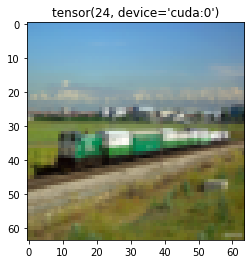

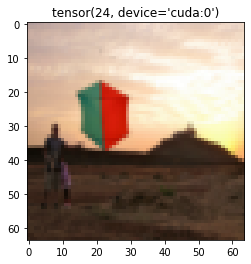

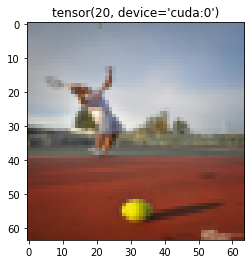

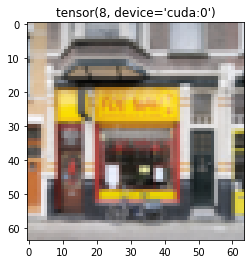

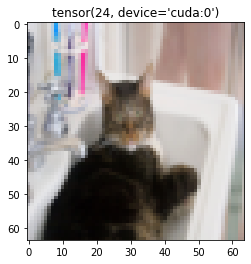

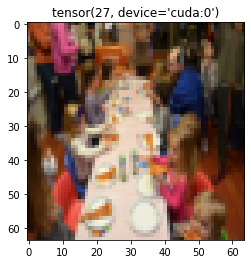

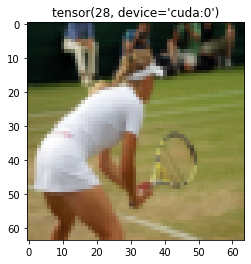

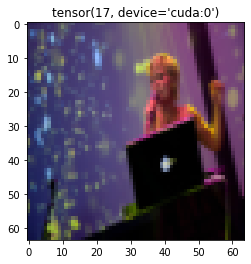

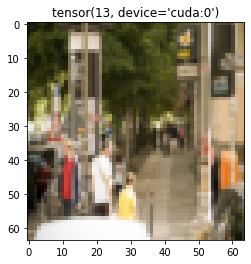

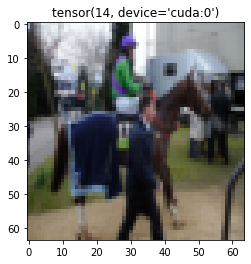

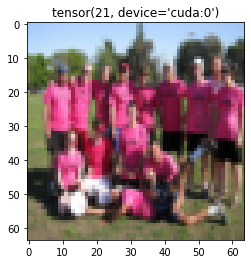

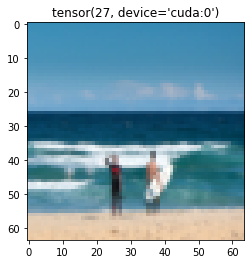

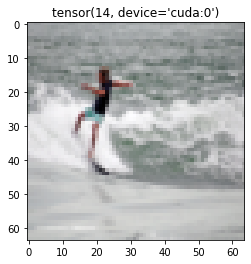

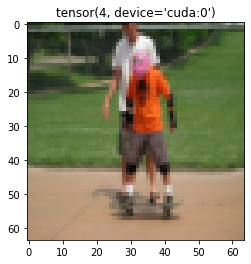

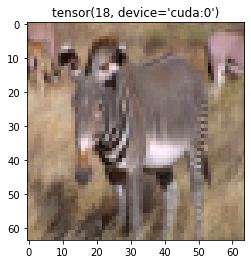

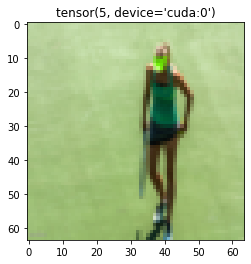

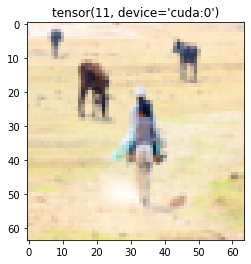

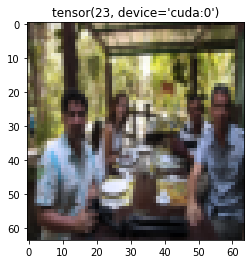

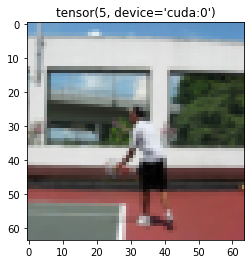

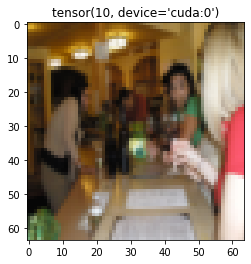

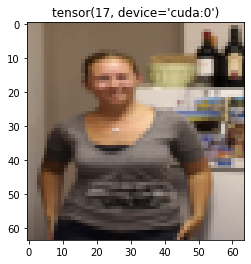

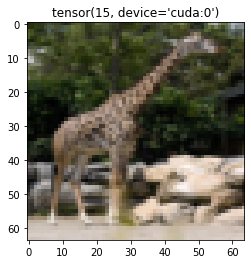

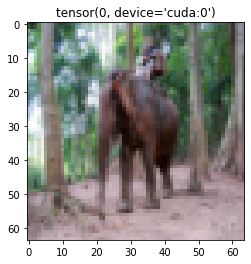

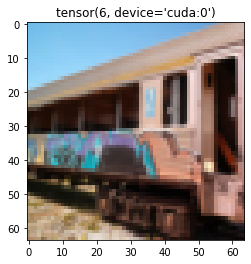

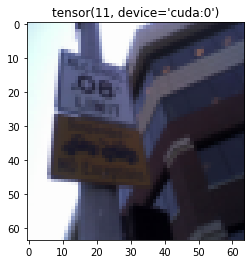

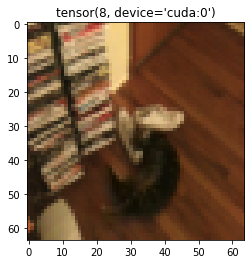

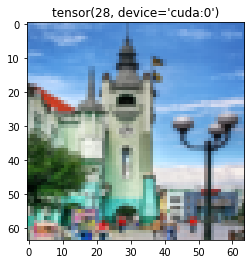

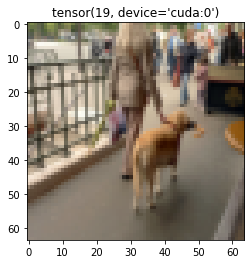

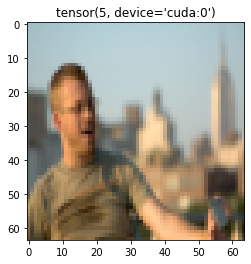

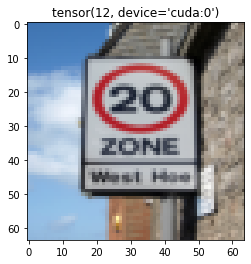

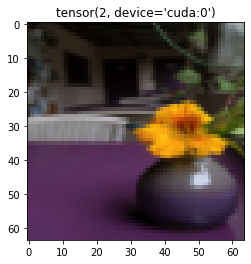

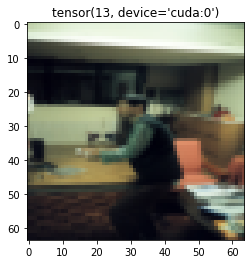

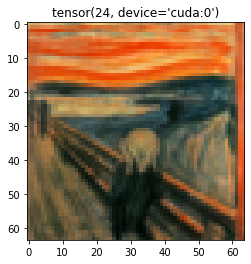

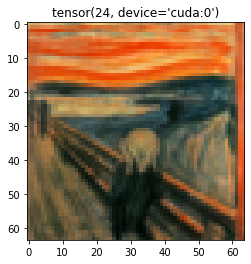

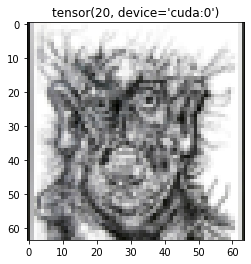

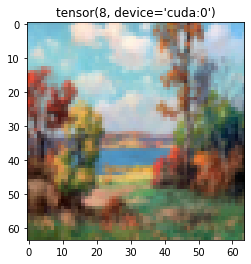

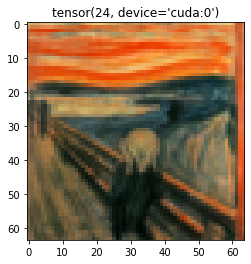

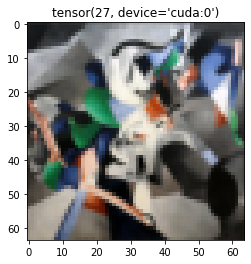

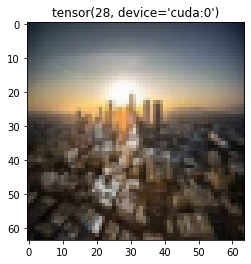

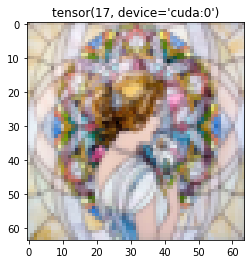

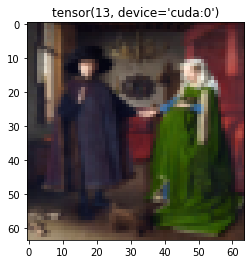

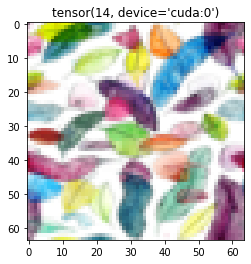

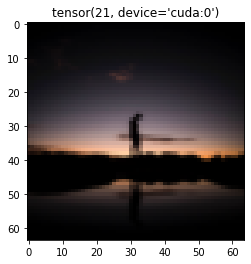

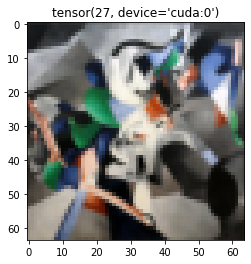

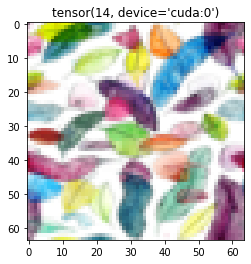

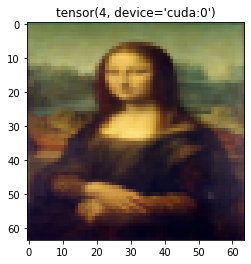

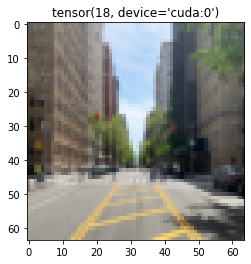

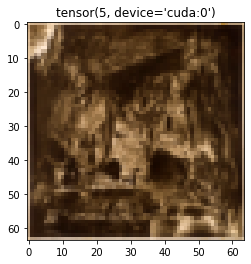

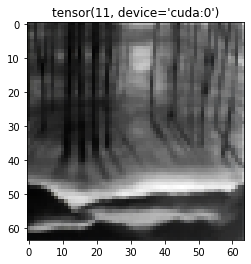

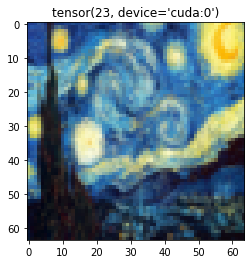

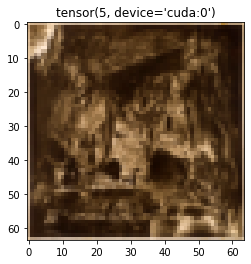

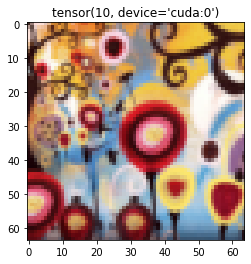

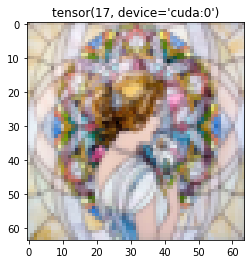

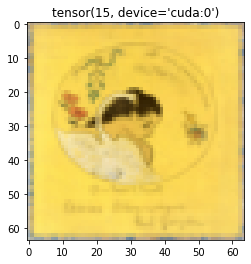

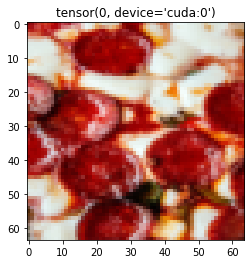

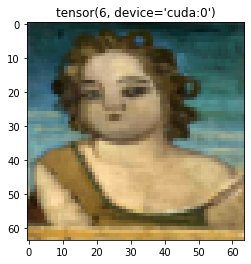

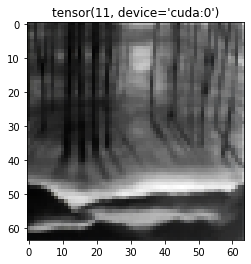

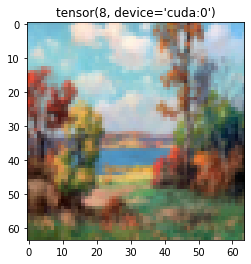

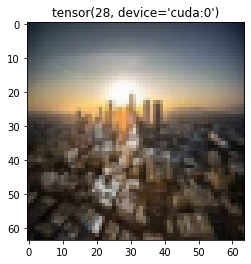

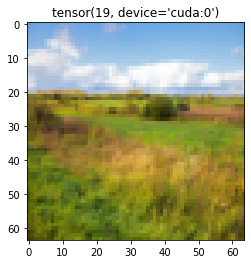

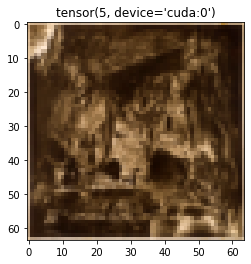

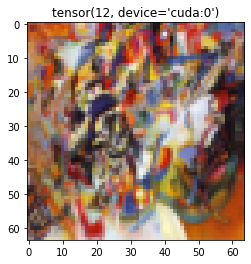

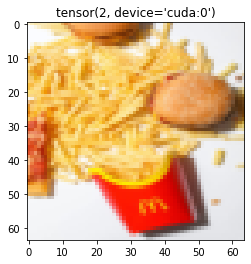

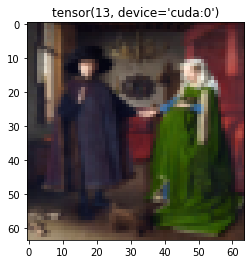

In [13]:
main(args)